# <center>**Classification of 10 Categories of Animals**</center>

Setup

In [41]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn.utils import shuffle
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, applications
from keras.models import Sequential, Model
from keras.layers import Flatten
from keras.callbacks import ModelCheckpoint

1. Loading data

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.1 Extracting data

In [2]:
!pwd

/c/Users/agbad/OneDrive/Desktop/vick/Data_j/DataProjects/animal_classification


In [3]:
folders = os.listdir('2/raw-img')

categories = [] # list of all ten categories present in the data
files = [] # list of all files in all categories

for k, folder in enumerate(folders):
    foldernames = os.listdir('2/raw-img/' + folder)
    for file in foldernames:
        files.append('2/raw-img/' + folder + '/' + file)
        categories.append(k)

df = pd.DataFrame({'imagefile': files, 'category': categories})
df.head()

,imagefile,category
0,2/raw-img/cane/OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg,0
1,2/raw-img/cane/OIP---A27bIBcUgX1qkbpZOPswHaFS....,0
2,2/raw-img/cane/OIP---cByAiEbIxIAleGo9AqOQAAAA....,0
3,2/raw-img/cane/OIP---ZIdwfUcJeVxnh47zppcQHaFj....,0
4,2/raw-img/cane/OIP---ZRsOF7zsMqhW30WeF8-AHaFj....,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26179 entries, 0 to 26178
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   imagefile  26179 non-null  object
 1   category   26179 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 409.2+ KB


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.2 Define training data

In [5]:
# collect 500 samples from each category to make the training data 
train_data = df.groupby('category').apply(lambda x: x.sample(1000)).reset_index(drop=True)

print(train_data.category.value_counts(), "\n")
print(train_data)

category
0    1000
1    1000
2    1000
3    1000
4    1000
5    1000
6    1000
7    1000
8    1000
9    1000
Name: count, dtype: int64 

                                              imagefile  category
0     2/raw-img/cane/OIP-jefAfIq6FJoTVNl40u6H2QHaGV....         0
1     2/raw-img/cane/OIP-NUY2fjRZfCpfcBUSK08WTwHaJ3....         0
2     2/raw-img/cane/OIP-Vskn75KO34VTqVff9P0xIAHaE7....         0
3     2/raw-img/cane/OIP-D2d-6nMVB46QCp82PwbKBQHaDt....         0
4     2/raw-img/cane/OIP-x9Dc7A0k2NT5cXqmBw2pYQHaIY....         0
...                                                 ...       ...
9995  2/raw-img/scoiattolo/OIP-ygfPaNnmUlnetNn9zAZMd...         9
9996  2/raw-img/scoiattolo/OIP-2pyGQ1Z-1ZqmxsX0NF6Lp...         9
9997  2/raw-img/scoiattolo/OIP-tL1_XF3X_cD_SOBQUUhbo...         9
9998  2/raw-img/scoiattolo/OIP-nHfof-ELuAd1B0NkdP6ky...         9
9999  2/raw-img/scoiattolo/OIP-vB2AnLR33Hqy7McabJTYZ...         9

[10000 rows x 2 columns]


C:\Users\agbad\AppData\Local\Temp\ipykernel_107128\630313292.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_data = df.groupby('category').apply(lambda x: x.sample(1000)).reset_index(drop=True)


In [6]:
# shuffle data for training
x = train_data['imagefile']
y = train_data['category']

x, y = shuffle(x, y)
print(x, "\n", y)

4752    2/raw-img/gallina/OIP-DvO6bpw0tKDxl1zXAfjphAHa...
5782                              2/raw-img/gatto/99.jpeg
7966    2/raw-img/pecora/OIP-XkY-fqwIfjFfOUgqbqjrewHaH...
4994    2/raw-img/gallina/OIP-eGxOW9-JX-j1ScXblvriAgHa...
6971    2/raw-img/mucca/OIP-Pq2cLPPiUiI1zOpLUh0lbwHaEK...
                              ...                        
5847                            2/raw-img/gatto/1223.jpeg
1334    2/raw-img/cavallo/OIP-TbL_qmHFbvM9lLxWSKY8UgHa...
8279    2/raw-img/ragno/OIP-FmilYKpC9SMnqqLaqoEPJwHaGD...
1997    2/raw-img/cavallo/OIP-5WUuUPhVaDotWnd2z7PLPAHa...
3987    2/raw-img/farfalla/OIP-cHIZKDx4pkDkFdLHDnKl4wH...
Name: imagefile, Length: 10000, dtype: object 
 4752    4
5782    5
7966    7
4994    4
6971    6
       ..
5847    5
1334    1
8279    8
1997    1
3987    3
Name: category, Length: 10000, dtype: int64


2. Image Preprocessing

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.1 Resizing and reshaping images

In [7]:
def centering_img(img):
    """
    Centering an image. We will add padding to the image to make it 256x256
    The original image will be in the center.

    Args:
        img: a numpy array representing an image
    Returns:
        a numpy array representing the centered image
    """

    size = [256, 256]
    img_size = img.shape[:2] # extract height and width from (height, width, channels)

    height_pad = (size[0] - img_size[0]) // 2
    width_pad = (size[1] - img_size[1]) // 2

    # create a new image and fill it with white/black
    new_img = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    new_img[height_pad:height_pad + img.shape[0], width_pad:width_pad + img.shape[1]] = img

    return new_img

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.2 Image resizing and conversion to array

In [8]:
images = []

with tqdm(total=len(train_data)) as k:
    for i, file_path in enumerate(train_data['imagefile']):
        img = cv2.imread(file_path) # read image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert to RGB as OpenCV reads in BGR but most CNN models expect RGB
        
        # resize image keeping the aspect ratio (one side will be 256px and the other will be <= 256px)
        if img.shape[0] > img.shape[1]:
            tile_size = (int(img.shape[1]*256/img.shape[0]), 256)
        else:
            tile_size = (256, int(img.shape[0]*256/img.shape[1]))

        # center the image in a 256x256 white background
        img = centering_img(cv2.resize(img, dsize=tile_size))

        # convert to 224*224
        img = img[16:240, 16:240]
        images.append(img)
        k.update(1)

images = np.array(images)

  0%|          | 0/10000 [00:00<?, ?it/s]

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.3 Image visualization

In [9]:
train_data

,imagefile,category
0,2/raw-img/cane/OIP-jefAfIq6FJoTVNl40u6H2QHaGV....,0
1,2/raw-img/cane/OIP-NUY2fjRZfCpfcBUSK08WTwHaJ3....,0
2,2/raw-img/cane/OIP-Vskn75KO34VTqVff9P0xIAHaE7....,0
3,2/raw-img/cane/OIP-D2d-6nMVB46QCp82PwbKBQHaDt....,0
4,2/raw-img/cane/OIP-x9Dc7A0k2NT5cXqmBw2pYQHaIY....,0
...,...,...
9995,2/raw-img/scoiattolo/OIP-ygfPaNnmUlnetNn9zAZMd...,9
9996,2/raw-img/scoiattolo/OIP-2pyGQ1Z-1ZqmxsX0NF6Lp...,9
9997,2/raw-img/scoiattolo/OIP-tL1_XF3X_cD_SOBQUUhbo...,9
9998,2/raw-img/scoiattolo/OIP-nHfof-ELuAd1B0NkdP6ky...,9


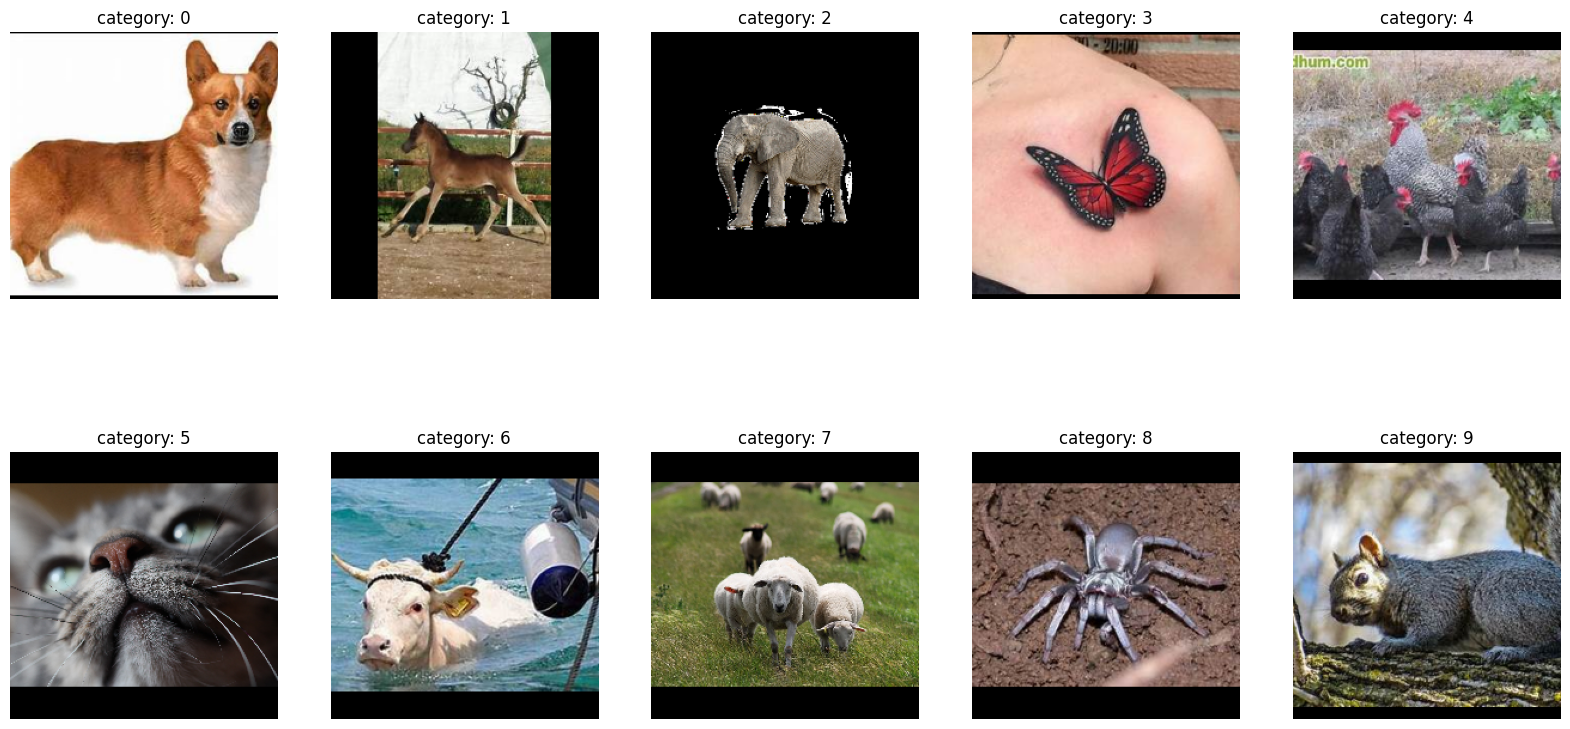

In [10]:
# visualize one image of each category
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for i, ax in enumerate(axes.flat):
    img = images[train_data[train_data['category'] == i].index[0]]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"category: {i}")

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.4 Re-shuffle processed data for optimal training

In [11]:
x_shuffle = []
y_shuffle = []
random_index = np.random.permutation(len(images))

for i in tqdm(range(len(images))):
    x_shuffle.append(images[random_index[i]])
    y_shuffle.append(y[random_index[i]])

x = np.array(x_shuffle)
y = np.array(y_shuffle)

  0%|          | 0/10000 [00:00<?, ?it/s]

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.5 Train-Validation split

In [12]:
train_size = int(len(x) * 0.8)
x_train, x_val = x[:train_size], x[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

print(f'x_train shape: {x_train.shape}, y_train shape: {y_train.shape}',"\n",
      f'x_val shape: {x_val.shape}, y_val shape: {y_val.shape}',"\n",
      f'image shape: {x_train[0].shape}')

x_train shape: (8000, 224, 224, 3), y_train shape: (8000,) 
 x_val shape: (2000, 224, 224, 3), y_val shape: (2000,) 
 image shape: (224, 224, 3)


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.6 Data Augmentation

We apply random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.

[Data Augmentation Article](https://pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/)

In [13]:
# create a data generator
train_datagen = ImageDataGenerator(rotation_range=30,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

train_datagen.fit(x_train)

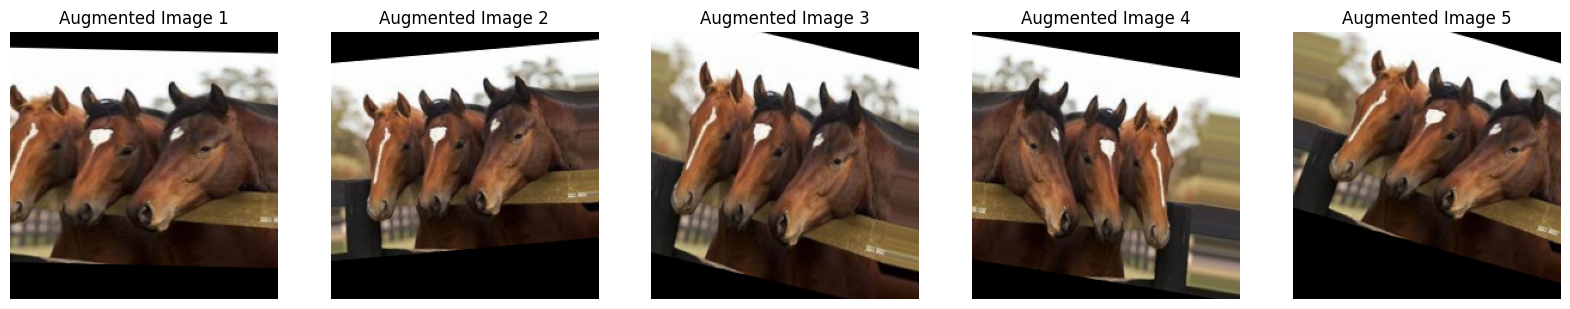

In [16]:
# visualize the transformations made on a single image
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
img = x_train[14] # choose a random image from the training set

# reshape the image to (1, height, width, channels) as the generator expects a batch
img = img.reshape((1,) + img.shape)

# generate batches of augmented images
augmented_images = train_datagen.flow(img)

for i, ax in enumerate(axes.flat):
    # get the next augmented image
    augmented_image = next(augmented_images)[0].astype('uint8')
    ax.imshow(augmented_image)
    ax.axis('off')
    ax.set_title(f"Augmented Image {i+1}")

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.7 Preprocessing test data

In [22]:
df.head()

,imagefile,category
0,2/raw-img/cane/OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg,0
1,2/raw-img/cane/OIP---A27bIBcUgX1qkbpZOPswHaFS....,0
2,2/raw-img/cane/OIP---cByAiEbIxIAleGo9AqOQAAAA....,0
3,2/raw-img/cane/OIP---ZIdwfUcJeVxnh47zppcQHaFj....,0
4,2/raw-img/cane/OIP---ZRsOF7zsMqhW30WeF8-AHaFj....,0


In [31]:
# define test data
test_data = []
actual_category =[]

for i in tqdm(range(10)):
    category_data = df[df['category'] == i]
    test_data.append(category_data.iloc[1001:1005, :1])
    actual_category.append(category_data.iloc[1001:1005, 1:])

test_data = pd.concat(test_data, ignore_index=True)
actual_category = pd.concat(actual_category, ignore_index=True)

test_images = []

# preprocess test images
with tqdm(total=len(test_data)) as k:
    for i, file_path in enumerate(test_data['imagefile']):
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if img.shape[0] > img.shape[1]:
            tile_size = (int(img.shape[1]*256/img.shape[0]), 256)
        else:
            tile_size = (256, int(img.shape[0]*256/img.shape[1]))

        img = centering_img(cv2.resize(img, dsize=tile_size))
        img = img[16:240, 16:240]
        test_images.append(img)
        k.update(1)

test_images = np.array(test_images).reshape(-1, 224, 224, 3)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

3. Developing Neural Networks

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.1 VGG-16 Model

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Geeks for Geeks article on VGG-166](https://www.geeksforgeeks.org/vgg-16-cnn-model/)

In [40]:
lr = 0.001
epochs = 25
momentum = 0.8
sgd = optimizers.SGD(learning_rate=lr, 
                     momentum=momentum,
                     nesterov=False)

# load the pre-trained model
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# freeze the base model
base_model.trainable = False

# add a custom classifier
model = Sequential()
model.add(Flatten(input_shape=base_model.output_shape[1:])) # the VGG-16 model has a 3D output shape but dense layer expects 1D input
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# combine the base model and the custom classifier
vgg16_model = Model(inputs=base_model.input, outputs=model(base_model.output))

# compile the model
vgg16_model.compile(optimizer=sgd, 
                    loss='sparse_categorical_crossentropy', 
                    metrics=['accuracy'])

vgg16_model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step


c:\Users\agbad\newenv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 10)             │     6,425,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,140,042 (80.64 MB)

 Trainable params: 6,425,354 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.2 Training the model

In [42]:
batch_size = 32
epochs = 25

neural_network = vgg16_model.fit_generator(train_datagen.flow(x_train, y_train, batch_size=batch_size),
                                           steps_per_epoch=len(x_train) // batch_size,
                                           epochs=epochs,
                                           validation_data=(x_val, y_val),
                                           callbacks=[ModelCheckpoint('VGG16-transferlearning.model',
                                                                      monitor='val_loss',
                                                                      save_best_only=True)] )

AttributeError: 'Functional' object has no attribute 'fit_generator'